# Cтруктурные, физико-химические и дескрипторы Шредингера из программы QikProp

План:
1. Построение структурных, физико-химических и дескрипторов Шредингера (QikProp)
2. Оценка корреляции дескрипторов с pIC50
3. Feature permutation на объединенных дескрипторах
4. Построение RandomForestClassifier и конесенсусной модели RF + CatBoost
5. Вывод. Данные дескрипторы несколько хуже влияют на целевую метрику roc_auc на test-данных, однако модель на данных дескрипторах способна находить различия в in-house данных, объединенных со стадартыми, используемыми in_vitro. Минус: модель переобучена, все метрики roc_auc на in_house данных лежат в диапазон 0.5-0

In [79]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
#import mols2grid
# mols2grid.useSVG=True
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from sklearn.preprocessing import FunctionTransformer
from pandas import DataFrame
import pickle
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, Draw, DataStructs
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import VotingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from matplotlib.pyplot import figure
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [11]:
data = Chem.SDMolSupplier('herg_smaller_right.sdf')

In [12]:
df = PandasTools.LoadSDF('herg_smaller_right.sdf')


,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.95,14.0,1,7.853872,,
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1,7.492144,,
2,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.38,5950.0,1,5.225483,,
3,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1,6.844664,,
4,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1,6.707744,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,,
7875,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,,
7876,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,,
7877,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,,

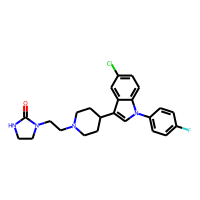
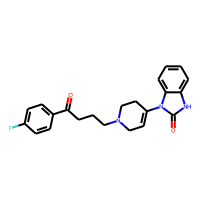
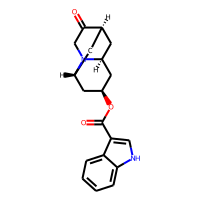
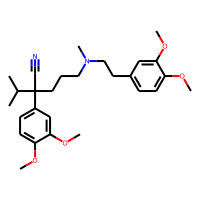
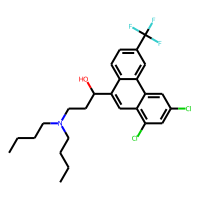
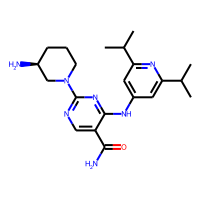
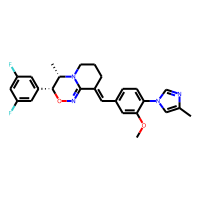
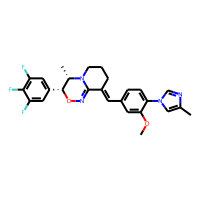
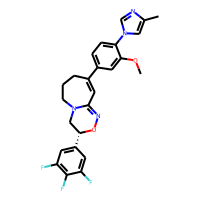
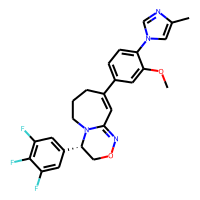

In [13]:
df

In [14]:
df_val = pd.read_csv('herg_valid_set.csv', sep = ",", engine='python')

In [15]:
def standardize_smiles(df, col_smiles):
    logs = 0
    mols = []
    for i in df[col_smiles]:    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Errors: {logs}")
    df["ROMol"] = mols
    return df

In [16]:
df_val = standardize_smiles(df_val, "SMILES")


Errors: 0


In [17]:
# создаем словарь из дескриторов структуры (Lipinski module)
ConstDescriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
                    "NHOHCount": Descriptors.NHOHCount,
                    "NOCount": Descriptors.NOCount,
                    "NumHAcceptors": Descriptors.NumHAcceptors,
                    "NumHDonors": Descriptors.NumHDonors,
                    "NumHeteroatoms": Descriptors.NumHeteroatoms,
                    "NumRotatableBonds": Descriptors.NumRotatableBonds,
                    "NumValenceElectrons": Descriptors.NumValenceElectrons,
                    "NumAromaticRings": Descriptors.NumAromaticRings,
                    "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
                    "RingCount": Descriptors.RingCount,
                    "fr_Al_COO": Descriptors.fr_Al_COO,
                    "fr_Al_OH": Descriptors.fr_Al_OH,
                    "fr_amide": Descriptors.fr_amide,
                    "fr_NH0": Descriptors.fr_NH0,
                    "fr_alkyl_halide": Descriptors.fr_alkyl_halide,
                    "fr_hdrzone": Descriptors.fr_hdrzone,
                    "fr_thiazole": Descriptors.fr_thiazole,
                    "CalcFractionCSP3": rdMolDescriptors.CalcFractionCSP3
                   }

# создаем словарь из физико-химических дескрипторов                            
PhisChemDescriptors = {"MW": Descriptors.MolWt,
                       "LogP": Descriptors.MolLogP,
                       "MR": Descriptors.MolMR,
                       "TPSA": Descriptors.TPSA}

# объединяем все дескрипторы в один словарь
descriptors = {}
descriptors.update(ConstDescriptors)
descriptors.update(PhisChemDescriptors)
print(f"Количество дескрипторов в словаре: {len(descriptors)}")


# функция для генерации дескрипторов из молекул
def mol_dsc_calc(mols): 
    return DataFrame({k: f(m) for k, f in descriptors.items()} 
             for m in np.array(mols).ravel())

# оформляем sklearn трансформер для использования в конвеерном моделировании (sklearn Pipeline)
descriptors_transformer = FunctionTransformer(mol_dsc_calc, validate=False)

Количество дескрипторов в словаре: 23


In [18]:
X = descriptors_transformer.transform(df["ROMol"])
df_val_d = descriptors_transformer.transform(df_val["ROMol"])

In [20]:
scaler = StandardScaler()
scaler.fit(X.values)
X_norm_SS = DataFrame(scaler.transform(X.values), index=X.index, columns=X.columns)
scaler.fit(df_val_d.values)
df_norm = DataFrame(scaler.transform(df_val_d.values), index=df_val_d.index, columns=df_val_d.columns)

In [21]:
X_norm_SS["pIC50"] = df["pIC50"]
X_norm_SS["value_nM"] = df["value_nM"]
X_norm_SS

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,...,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,MR,TPSA,pIC50,value_nM
0,-0.035489,-0.451597,-0.664710,-1.238277,-0.341768,-0.375266,-0.266769,-0.048056,0.174456,0.908204,...,-0.451618,-0.090263,-0.235266,-0.014964,0.029141,0.612484,0.152088,-1.215002,7.853872,14.0
1,-0.522345,-0.451597,-0.664710,-0.776436,-0.341768,-0.750341,0.157252,-0.597150,0.174456,-0.184943,...,-0.451618,-0.090263,-0.235266,-0.684660,-0.681260,-0.075102,-0.464118,-0.654453,7.492144,32.2
2,-1.171486,-0.451597,-0.664710,-0.776436,-0.341768,-1.125416,-1.538833,-1.207254,-0.801086,3.094496,...,-0.451618,-0.090263,-0.235266,0.631234,-1.317058,-0.914953,-1.318618,-0.517423,5.225483,5950.0
3,0.289082,-1.240539,-0.232879,0.147245,-1.290938,-0.750341,3.125402,0.501038,-0.801086,-1.278089,...,-0.451618,-0.090263,-0.235266,0.924816,0.186904,0.949670,0.600553,-0.468028,6.844664,143.0
4,0.289082,-0.451597,-1.960203,-1.700118,-0.341768,-0.375266,1.853338,0.501038,0.174456,-1.278089,...,1.849005,-0.090263,-0.235266,0.551702,0.716064,3.522118,0.629752,-1.758024,6.707744,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,-0.360060,2.704174,0.630784,0.609086,1.556570,-0.000190,0.157252,-0.231087,-0.801086,-0.184943,...,-0.451618,-0.090263,-0.235266,0.959462,-0.472326,-0.647365,-0.114482,1.415341,5.431798,3700.0
7875,0.451367,-1.240539,-0.232879,0.147245,-1.290938,-0.000190,-0.690790,0.379017,0.174456,0.908204,...,-0.451618,-0.090263,-0.235266,-0.455704,0.301291,1.186645,0.340902,-0.852669,5.697453,2007.0
7876,0.613652,-1.240539,-0.232879,0.147245,-1.290938,0.374885,-0.690790,0.562049,0.174456,0.908204,...,-0.451618,-0.090263,-0.235266,-0.455704,0.509047,1.287407,0.339024,-0.852669,5.793984,1607.0
7877,0.451367,-1.240539,-0.232879,0.147245,-1.290938,0.374885,-0.690790,0.379017,0.174456,0.908204,...,-0.451618,-0.090263,-0.235266,-0.637038,0.347057,1.005984,0.133495,-0.852669,5.474696,3352.0


In [22]:
X_norm_SS["pIC50"] = pd.to_numeric(X_norm_SS["pIC50"])
X_norm_SS["value_nM"] = pd.to_numeric(X_norm_SS["value_nM"])

In [23]:
X_norm_SS.to_csv("descriptors_struct_phys.csv", encoding='utf-8', index=False)

In [24]:

corr_df_pearson = X_norm_SS.corr(method="pearson")
corr_df_pearson[np.abs(corr_df_pearson['pIC50']) > 0.1]['pIC50']

NHOHCount           -0.127915
NOCount             -0.188791
NumHAcceptors       -0.151797
NumHDonors          -0.134530
NumHeteroatoms      -0.173832
NumRotatableBonds    0.115200
fr_amide            -0.132064
LogP                 0.269417
TPSA                -0.225118
pIC50                1.000000
value_nM            -0.116362
Name: pIC50, dtype: float64

In [25]:
# ! conda install seaborn -y

<AxesSubplot:>

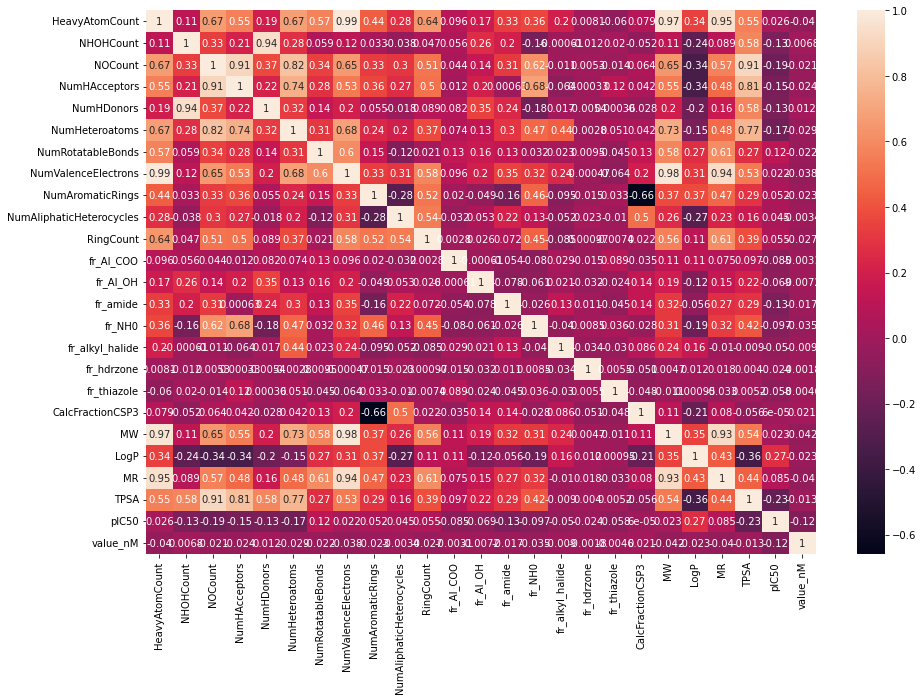

In [28]:

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df_pearson, annot = True)

Единственная корреляция - с LogP  и TPSA

* LogP = Predicted octanol/water partition coefficient
* TPSA = topological polar surface area (TPSA) of a molecule is defined as the surface sum over all polar atoms or molecules, primarily oxygen and nitrogen, also including their attached hydrogen atoms.

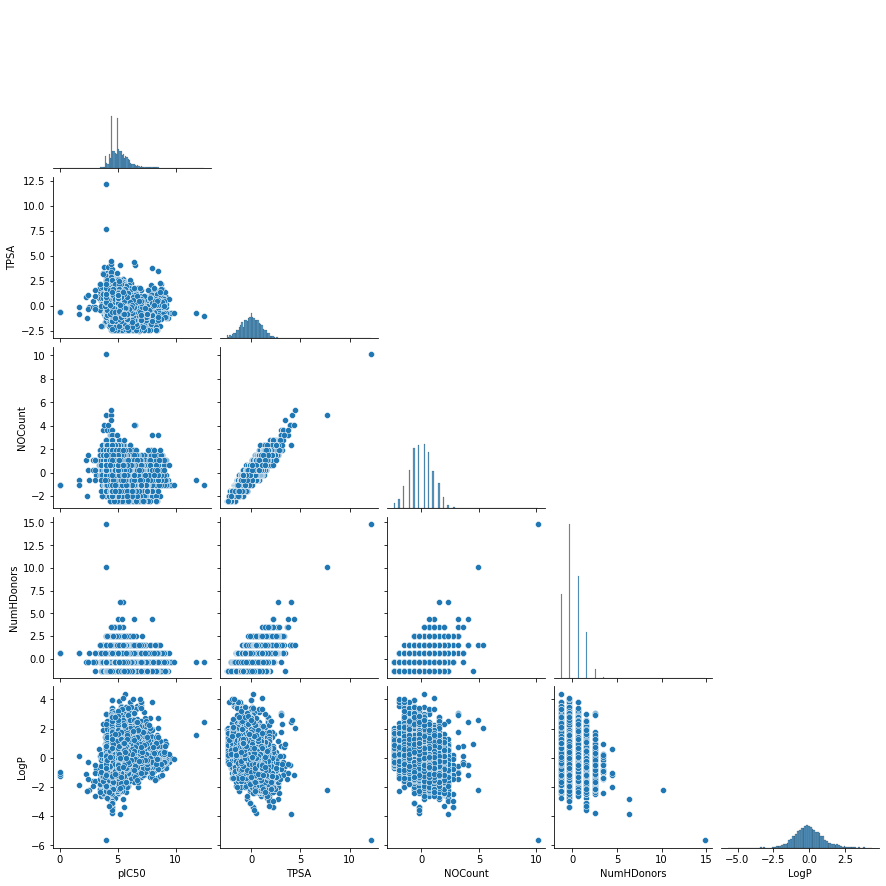

In [29]:
sns.pairplot(X_norm_SS[["pIC50", "TPSA", "NOCount", "NumHDonors","LogP"]], corner=True)

значимой корреляции pIC50 с  LogP не видно

Попробуем комбинации:

In [30]:
X_norm_SS["LogP_NumRotatableBonds_NumAromaticRings"] = X_norm_SS[["LogP","NumRotatableBonds","NumAromaticRings"]].sum(axis=1)
X_norm_SS["TPSA_NOCount"] = X_norm_SS[["TPSA","NOCount"]].sum(axis=1)

In [31]:
df_test = X_norm_SS[["pIC50",
                  "LogP_NumRotatableBonds_NumAromaticRings",
                  "TPSA_NOCount"
                 ]]

In [32]:
corr_df_test_pearson = df_test.corr(method="pearson")
corr_df_test_pearson[np.abs(corr_df_test_pearson["pIC50"]) > 0.1]["pIC50"]

pIC50                                      1.000000
LogP_NumRotatableBonds_NumAromaticRings    0.203910
TPSA_NOCount                              -0.211518
Name: pIC50, dtype: float64

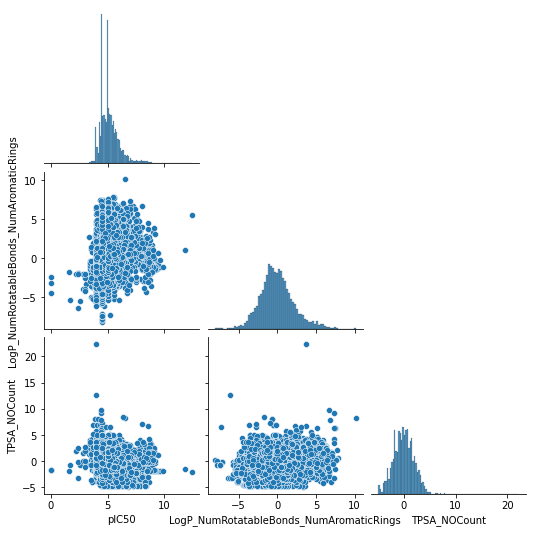

In [33]:
sns.pairplot(X_norm_SS[["pIC50", "LogP_NumRotatableBonds_NumAromaticRings", "TPSA_NOCount"]], corner=True)

Улучшения при линейной комбинациии признаков не наблюдается

# Дескрипторы Шредингера ( QikProp)

In [47]:
def read_csv_with_nan(csv_file):
    from csv import reader
    # open file in read mode
    with open(csv_file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        a = []
        for row in csv_reader:
            a.append(row)
            # row variable is a list that represents a row in csv
            # print(row)
    d_schroedinger = pd.DataFrame(a)
    d_schroedinger.columns = d_schroedinger.iloc[0]
    d_schroedinger = d_schroedinger[1:]
    d_schroedinger = d_schroedinger.loc[:, d_schroedinger.columns.notnull()]
    d_schroedinger.reset_index(drop=True, inplace=True)
    return d_schroedinger

In [48]:
d_schroedinger = read_csv_with_nan("qikprop_7k.csv")
d_schroedinger

,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,...,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,CHEMBL12713,1,1,0,0,0,3,0,1,440.947,...,53.329,5,1,26,0,26,7,31,1,0.000
1,CHEMBL1108,0,1,0,0,0,5,0,1,379.433,...,77.075,5,0,21,0,21,3,28,0,0.000
2,CHEMBL2368925,0,1,0,0,0,2,1,1,324.379,...,75.722,5,0,20,0,20,9,24,0,0.004
3,CHEMBL6966,0,1,0,0,0,14,0,1,454.608,...,51.629,6,0,12,0,12,0,33,0,0.747
4,CHEMBL1107,3,1,0,0,0,11,0,2,500.430,...,20.369,2,2,14,0,14,0,33,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,CHEMBL4635883,0,1,0,0,0,6,0,-1,397.522,...,114.703,8,0,18,0,18,5,29,0,0.000
7875,CHEMBL4643105,1,0,0,0,0,3,0,1,464.514,...,46.398,6,1,27,0,27,5,34,1,0.000
7876,CHEMBL4634921,2,0,0,0,0,3,0,1,482.504,...,46.395,6,1,27,0,27,5,35,1,0.000
7877,CHEMBL4634696,1,0,0,0,0,1,0,1,468.478,...,49.142,6,1,28,0,23,5,34,1,0.000


In [49]:
#new_df = d_schroedinger[d_schroedinger['molecule'].isin(df['molecule_chembl_id'])]

In [50]:
df_all = pd.concat([X_norm_SS,d_schroedinger],axis=1)

In [51]:
df_all = pd.concat([df_all,df["class"]],axis=1)


In [52]:
df_all = pd.concat([df_all,df["pIC50"]],axis=1)
df_all

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,...,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm,class,pIC50
0,-0.035489,-0.451597,-0.664710,-1.238277,-0.341768,-0.375266,-0.266769,-0.048056,0.174456,0.908204,...,1,26,0,26,7,31,1,0.000,1,7.853872
1,-0.522345,-0.451597,-0.664710,-0.776436,-0.341768,-0.750341,0.157252,-0.597150,0.174456,-0.184943,...,0,21,0,21,3,28,0,0.000,1,7.492144
2,-1.171486,-0.451597,-0.664710,-0.776436,-0.341768,-1.125416,-1.538833,-1.207254,-0.801086,3.094496,...,0,20,0,20,9,24,0,0.004,1,5.225483
3,0.289082,-1.240539,-0.232879,0.147245,-1.290938,-0.750341,3.125402,0.501038,-0.801086,-1.278089,...,0,12,0,12,0,33,0,0.747,1,6.844664
4,0.289082,-0.451597,-1.960203,-1.700118,-0.341768,-0.375266,1.853338,0.501038,0.174456,-1.278089,...,2,14,0,14,0,33,1,0.000,1,6.707744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,-0.360060,2.704174,0.630784,0.609086,1.556570,-0.000190,0.157252,-0.231087,-0.801086,-0.184943,...,0,18,0,18,5,29,0,0.000,1,5.431798
7875,0.451367,-1.240539,-0.232879,0.147245,-1.290938,-0.000190,-0.690790,0.379017,0.174456,0.908204,...,1,27,0,27,5,34,1,0.000,1,5.697453
7876,0.613652,-1.240539,-0.232879,0.147245,-1.290938,0.374885,-0.690790,0.562049,0.174456,0.908204,...,1,27,0,27,5,35,1,0.000,1,5.793984
7877,0.451367,-1.240539,-0.232879,0.147245,-1.290938,0.374885,-0.690790,0.379017,0.174456,0.908204,...,1,28,0,23,5,34,1,0.000,1,5.474696


In [53]:
df_all.isna().sum().sum()

0

In [54]:
def count_nan_index(df_all):
    k = 0
    l = 0
    index_nan = []
    for i in df_all["#stars"]:
        k += 1
        if i == "":
            index_nan.append(df_all.index[k-1])
            l += 1
    print(l)
    print(index_nan)
    return index_nan

In [55]:
index_nan = count_nan_index(df_all)

36
[87, 308, 3602, 3603, 3604, 3605, 3607, 3609, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 4904, 6723, 7292, 7293]


In [56]:
df_all.drop(df_all.index[index_nan], inplace=True)

In [57]:
df_all

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,...,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm,class,pIC50
0,-0.035489,-0.451597,-0.664710,-1.238277,-0.341768,-0.375266,-0.266769,-0.048056,0.174456,0.908204,...,1,26,0,26,7,31,1,0.000,1,7.853872
1,-0.522345,-0.451597,-0.664710,-0.776436,-0.341768,-0.750341,0.157252,-0.597150,0.174456,-0.184943,...,0,21,0,21,3,28,0,0.000,1,7.492144
2,-1.171486,-0.451597,-0.664710,-0.776436,-0.341768,-1.125416,-1.538833,-1.207254,-0.801086,3.094496,...,0,20,0,20,9,24,0,0.004,1,5.225483
3,0.289082,-1.240539,-0.232879,0.147245,-1.290938,-0.750341,3.125402,0.501038,-0.801086,-1.278089,...,0,12,0,12,0,33,0,0.747,1,6.844664
4,0.289082,-0.451597,-1.960203,-1.700118,-0.341768,-0.375266,1.853338,0.501038,0.174456,-1.278089,...,2,14,0,14,0,33,1,0.000,1,6.707744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,-0.360060,2.704174,0.630784,0.609086,1.556570,-0.000190,0.157252,-0.231087,-0.801086,-0.184943,...,0,18,0,18,5,29,0,0.000,1,5.431798
7875,0.451367,-1.240539,-0.232879,0.147245,-1.290938,-0.000190,-0.690790,0.379017,0.174456,0.908204,...,1,27,0,27,5,34,1,0.000,1,5.697453
7876,0.613652,-1.240539,-0.232879,0.147245,-1.290938,0.374885,-0.690790,0.562049,0.174456,0.908204,...,1,27,0,27,5,35,1,0.000,1,5.793984
7877,0.451367,-1.240539,-0.232879,0.147245,-1.290938,0.374885,-0.690790,0.379017,0.174456,0.908204,...,1,28,0,23,5,34,1,0.000,1,5.474696


Сохраним дескрипторы

In [58]:
df_all.to_csv("d_schroed_phys_chem_7843.csv", encoding='utf-8', index=False)

In [59]:
# df_all.dtypes

In [60]:
corr_df_pearson = df_all.corr(method="pearson")
corr_df_pearson[np.abs(corr_df_pearson['pIC50']) > 0.1]['pIC50']

NHOHCount                                 -0.123252
NOCount                                   -0.182853
NumHAcceptors                             -0.144300
NumHDonors                                -0.129873
NumHeteroatoms                            -0.167207
NumRotatableBonds                          0.111648
fr_amide                                  -0.128417
LogP                                       0.266844
TPSA                                      -0.219087
pIC50                                      1.000000
value_nM                                  -0.116898
LogP_NumRotatableBonds_NumAromaticRings    0.201021
TPSA_NOCount                              -0.205465
Name: pIC50, dtype: float64

<AxesSubplot:>

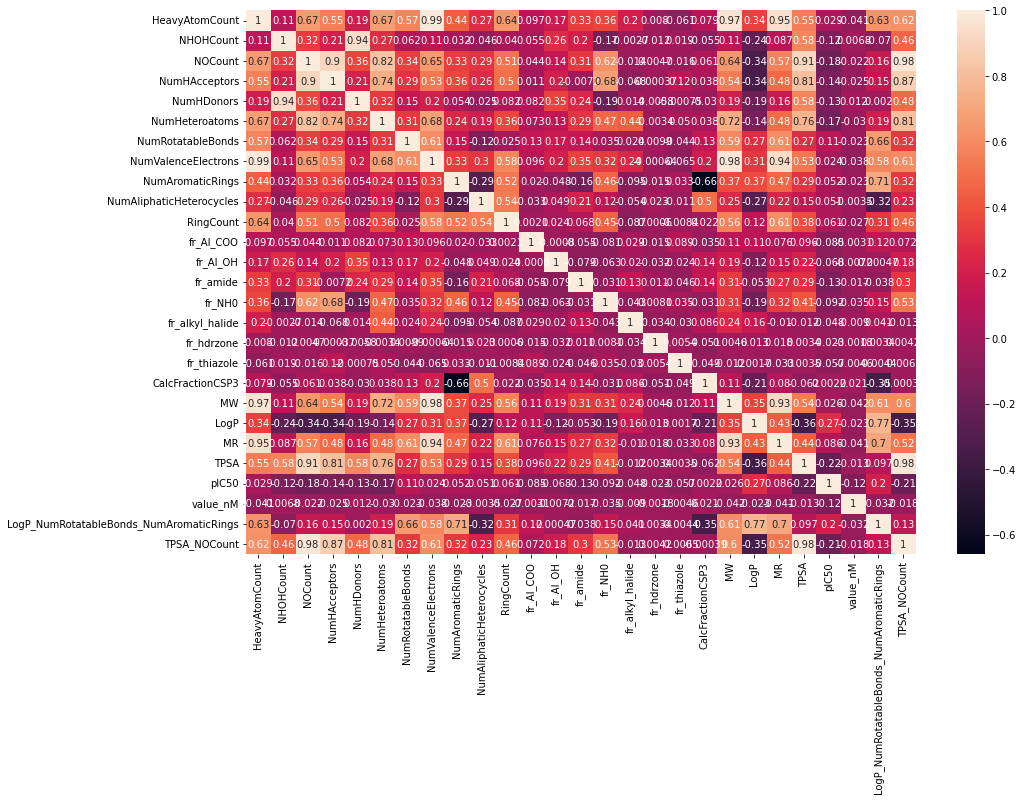

In [62]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df_pearson, annot = True)

Принципально новых корреляций не выявлено

In [63]:
df_x = df_all.drop(["class", 'pIC50', "molecule", "value_nM", 'QPlogHERG'], axis =1)

In [64]:
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)

In [65]:
df_x.astype(float)

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,fr_Al_COO,fr_Al_OH,fr_amide,fr_NH0,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,MR,TPSA,LogP_NumRotatableBonds_NumAromaticRings,TPSA_NOCount,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,-0.035489,-0.451597,-0.664710,-1.238277,-0.341768,-0.375266,-0.266769,-0.048056,0.174456,0.908204,0.582484,-0.161798,-0.380999,1.548919,-0.008447,-0.451618,-0.090263,-0.235266,-0.014964,0.029141,0.612484,0.152088,-1.215002,0.520171,-1.879712,1.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,440.947,7.294,761.664,293.212,83.169,266.744,118.538,1357.996,1.0,4.00,0.039181,0.005252,0.778635,48.814,13.861,20.711,8.717,5.802,-7.488,-6.655,401.892,0.158,911.323,-3.887,8.287,0.737,2.0,1.406,1.0,94.566,47.013,0.0,53.329,5.0,1.0,26.0,0.0,26.0,7.0,31.0,1.0,0.000
1,-0.522345,-0.451597,-0.664710,-0.776436,-0.341768,-0.750341,0.157252,-0.597150,0.174456,-0.184943,-0.247124,-0.161798,-0.380999,-0.927529,-0.592237,-0.451618,-0.090263,-0.235266,-0.684660,-0.681260,-0.075102,-0.464118,-0.654453,0.256607,-1.319163,0.0,1.0,0.0,0.0,0.0,5.0,0.0,1.0,379.433,5.335,688.755,177.594,125.727,338.396,47.039,1213.372,1.0,6.00,0.023458,0.008711,0.798785,42.426,12.714,19.294,10.822,3.501,-4.768,-4.546,158.684,-0.538,135.450,-4.227,8.729,0.849,4.0,0.516,3.0,86.833,47.039,0.0,77.075,5.0,0.0,21.0,0.0,21.0,3.0,28.0,0.0,0.000
2,-1.171486,-0.451597,-0.664710,-0.776436,-0.341768,-1.125416,-1.538833,-1.207254,-0.801086,3.094496,1.412093,-0.161798,-0.380999,-0.927529,-1.176028,-0.451618,-0.090263,-0.235266,0.631234,-1.317058,-0.914953,-1.318618,-0.517423,-3.254872,-1.182132,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,324.379,4.883,586.577,257.421,112.191,216.965,0.000,1029.591,0.0,5.00,0.023158,0.000000,0.840652,35.838,10.085,14.703,7.854,2.528,-3.170,-3.210,213.250,-0.217,103.000,-4.693,8.605,0.334,2.0,0.184,3.0,83.429,0.000,0.0,75.722,5.0,0.0,20.0,0.0,20.0,9.0,24.0,0.0,0.004
3,0.289082,-1.240539,-0.232879,0.147245,-1.290938,-0.750341,3.125402,0.501038,-0.801086,-1.278089,-1.906341,-0.161798,-0.380999,-0.927529,-0.592237,-0.451618,-0.090263,-0.235266,0.924816,0.186904,0.949670,0.600553,-0.468028,3.273986,-0.700907,0.0,1.0,0.0,0.0,0.0,14.0,0.0,1.0,454.608,6.826,678.150,557.072,36.750,84.328,0.000,1416.270,0.0,6.50,0.032899,0.000000,0.899366,42.341,12.123,17.312,5.489,4.027,-4.280,-6.384,1107.391,-0.185,611.102,-2.618,8.388,-0.121,6.0,0.396,3.0,100.000,0.000,0.0,51.629,6.0,0.0,12.0,0.0,12.0,0.0,33.0,0.0,0.747
4,0.289082,-0.451597,-1.960203,-1.700118,-0.341768,-0.375266,1.853338,0.501038,0.174456,-1.278089,-1.076732,-0.161798,1.849233,-0.927529,-1.176028,1.849005,-0.090263,-0.235266,0.551702,0.716064,3.522118,0.629752,-1.758024,5.549911,-3.718227,3.0,1.0,0.0,0.0,0.0,11.0,0.0,2.0,500.430,1.992,801.252,373.323,13.430,164.009,250.490,1471.548,1.0,3.70,0.002695,0.004618,0.780870,47.241,13.670,19.421,5.625,7.526,-7.605,-7.751,1842.638,0.767,10000.000,-2.196,8.868,1.494,2.0,1.449,1.0,100.000,117.620,0.0,20.369,2.0,2.0,14.0,0.0,14.0,0.0,33.0,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,-0.360060,2.704174,0.630784,0.609086,1.556570,-0.000190,0.157252,-0.231087,-0.801086,-0.184943,-1.076732,-0.161798,-0.380999,0.310695,0.575344,-0.451618,-0.090263,-0.235266,0.959462,-0.472326,-0.647365,-0.114482,1.415341,-1.291199,2.

Анализ feature importance объединенных дескрипторов Шредингера и структрных+физико-химических

In [66]:
Yc = df_all["class"]
X = df_x

X_train, X_test, y_train, y_test = train_test_split(X, Yc, shuffle=True, random_state=75, train_size=.8)

In [67]:


feature_names = [f'feature {i}' for i in df_x.columns]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [68]:

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.020 seconds


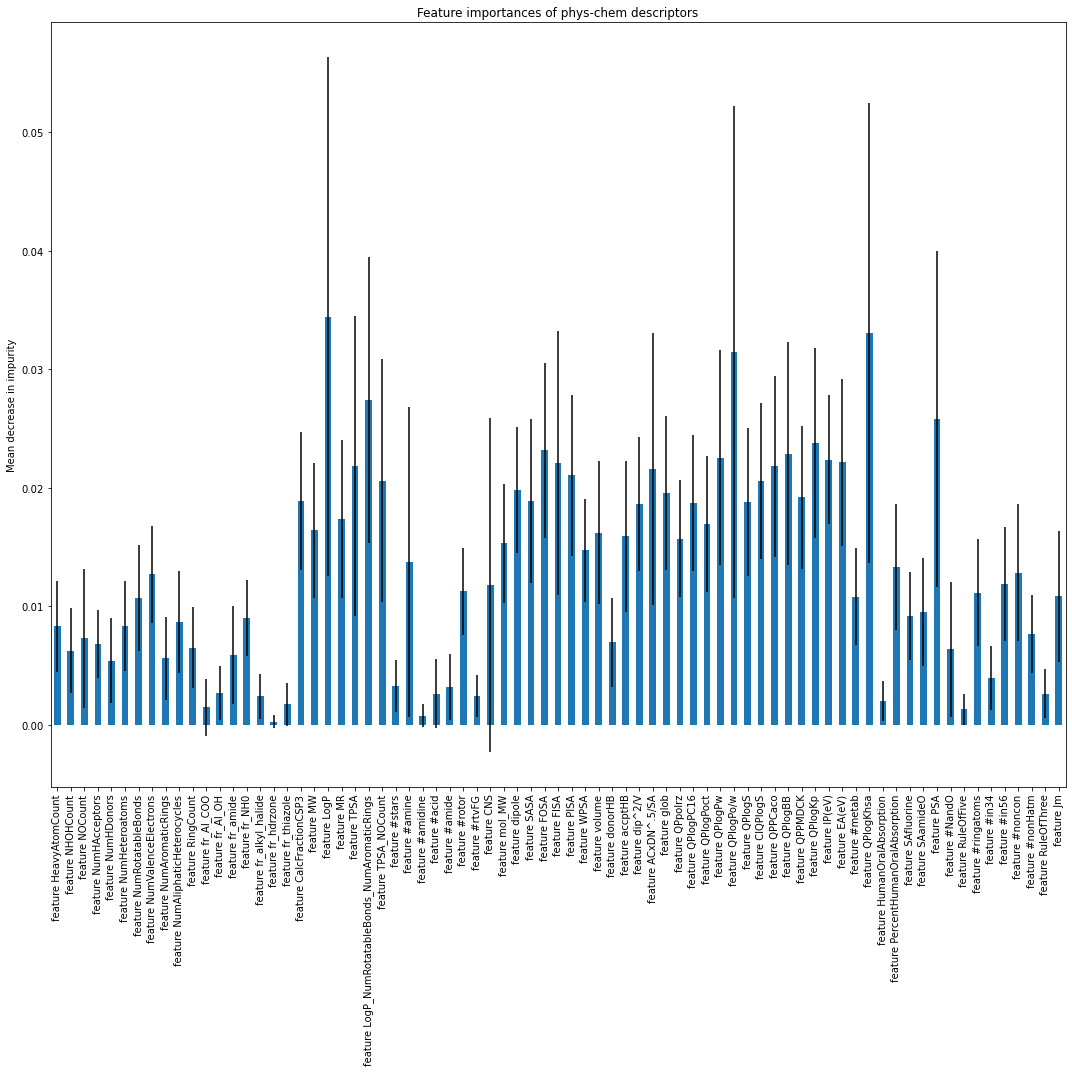

In [69]:

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15, 15))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances of phys-chem descriptors")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Но больше нас интереесует feature importance с permutation:

In [70]:

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 33.089 seconds


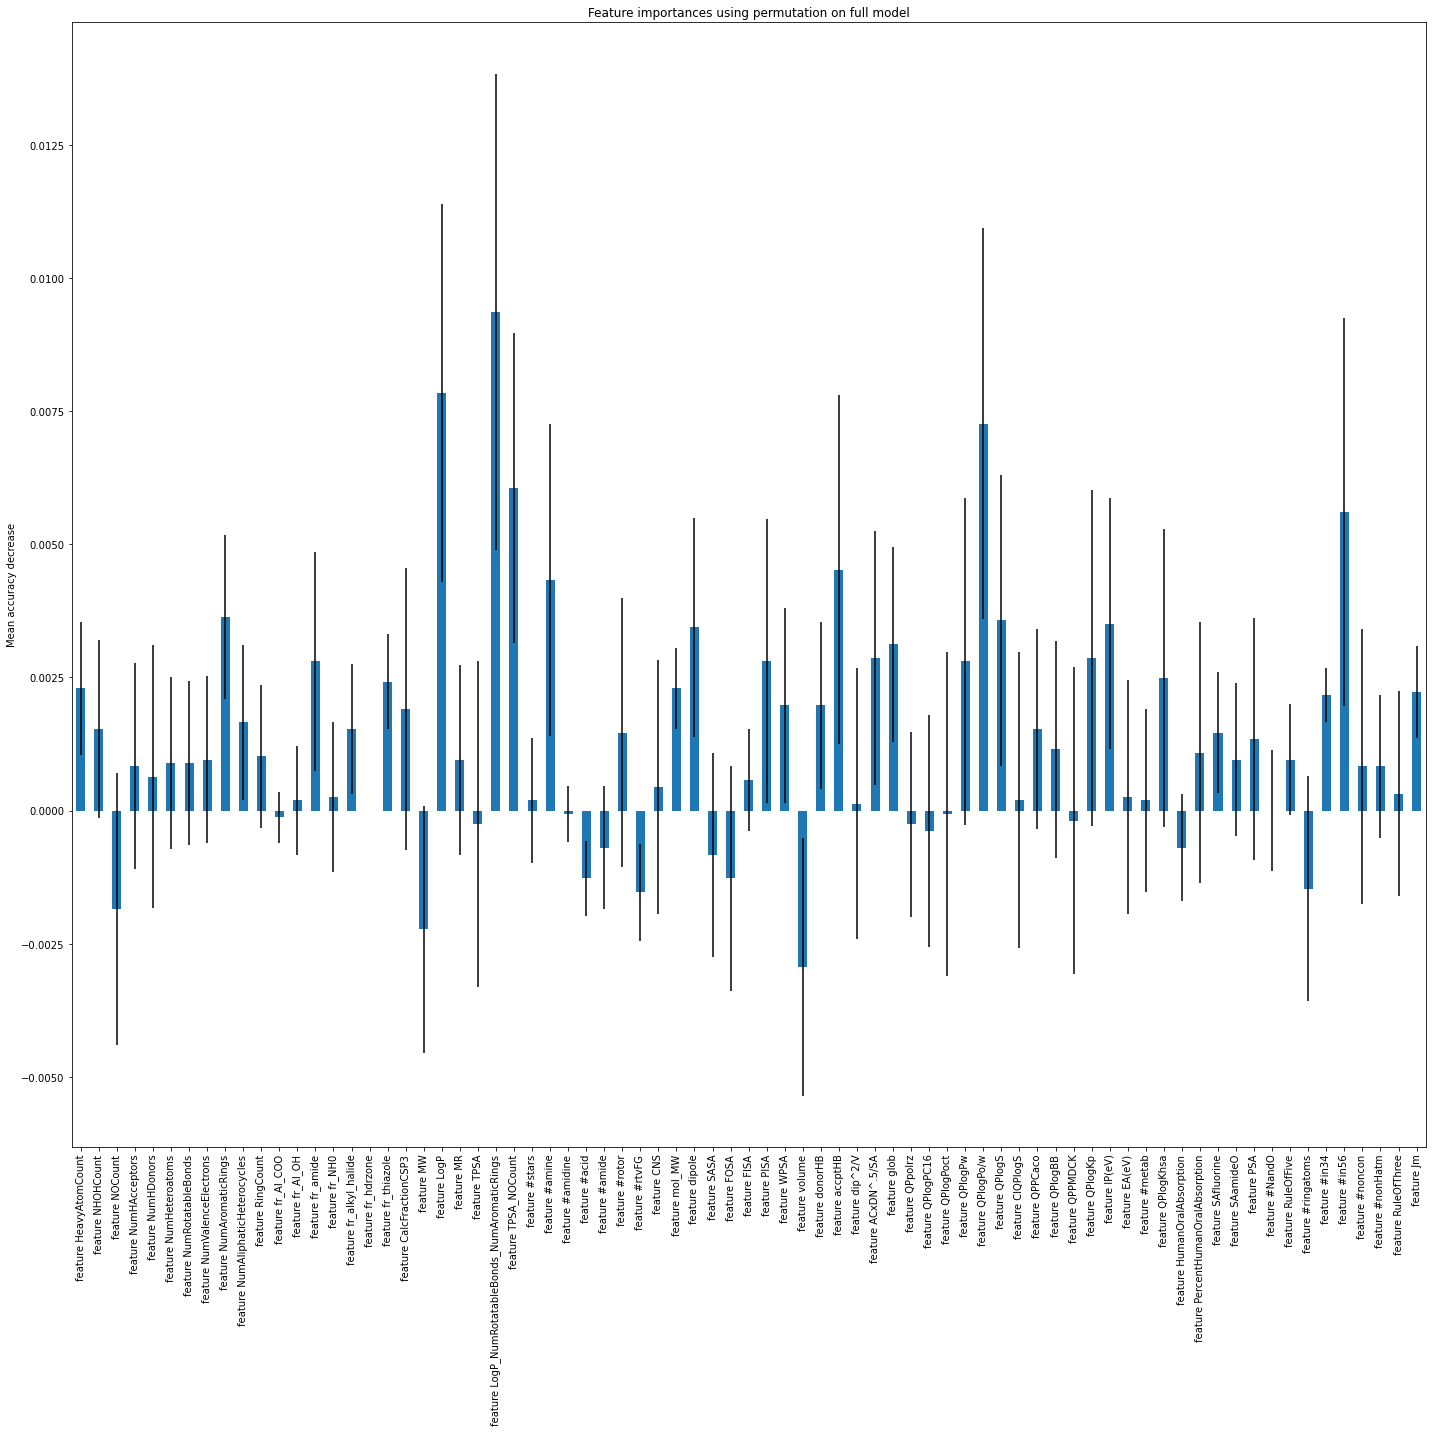

In [71]:
fig, ax = plt.subplots(figsize=(20,20))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [72]:
# d_schroedinger.dtypes

In [73]:
df_x1 = df_x[["LogP", "MR", "#amine", "CNS", 'dipole', 'ACxDN^.5/SA', 'glob', 'QPlogPo/w']]

In [90]:
#df_val_1 = df_val[["LogP", "MR", "#amine", "CNS", 'dipole', 'ACxDN^.5/SA', 'glob', 'QPlogPo/w']]

In [75]:
Yc = df_all["class"]
X = df_x1
X_train, X_test, y_train, y_test = train_test_split(X, Yc, shuffle=True, random_state=75, train_size=.8)

In [80]:
clf = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state=42)
print (np.mean(cross_val_score(clf, df_x1, Yc, scoring='roc_auc', cv=10)))

0.6504453074865504


In [81]:
filename = 'RF_Struct_descriptors.py'
pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [82]:
clf1 = RandomForestClassifier(random_state=42, n_estimators = 1000, criterion = 'entropy')
clf2 = CatBoostClassifier(learning_rate=0.1, loss_function='Logloss', verbose = False)

In [83]:
eclf = VotingClassifier(estimators=[('RF1', clf1), ('CatBoost', clf2)], voting ='soft', weights=[1, 1])

In [84]:
eclf = eclf.fit(X_train, y_train.astype(int))

In [85]:
filename = 'consensus_Struct_descriptors.py'
pickle.dump(eclf, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [86]:
def print_metrics(y_test, X_test, clf):
    y_testf1 = np.transpose((np.array(y_test)).astype(np.int64))
    zt = clf.predict(X_test).astype(np.int64)
    print(f"roc auc test_set = {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")
    print(f"bac test_set = {balanced_accuracy_score(y_test, clf.predict(X_test))}")
    print(f"acc test_set = {accuracy_score(y_test, clf.predict(X_test))}")
    print(f"f1_score ={f1_score(y_testf1, zt)}")
    print(f"recall_score ={recall_score(y_testf1, zt)}")
    print(f"precision_score ={precision_score(y_testf1, zt)}")

In [87]:
res = print_metrics(y_test.astype(int), X_test, eclf)

roc auc test_set = 0.7869315594300956
bac test_set = 0.7100822978335828
acc test_set = 0.7106437221159975
f1_score =0.6985391766268261
recall_score =0.6921052631578948
precision_score =0.7050938337801609


In [91]:
#res = print_metrics(df_val["class"], df_val_1, eclf)

Вывод
- В данном случае через feature importance (c permutation) было отобрано меньше дескрипторов (8: "LogP", "MR", "#amine", "CNS", 'dipole', 'ACxDN^.5/SA', 'glob', 'QPlogPo/w'), которые. в то же время имеют корреляцию с pIC50.
- Проблема с переобучением модели по-прежнему остается. 
